# 1. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings  
import math


import scipy
from scipy import stats
from scipy.stats import shapiro


from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest


from statsmodels.tsa.seasonal import STL


# 2. Data Loading and Preparation


In [4]:
data = pd.read_csv("dataset_mood_smartphone.csv")
print(data.info)
print(data.head())

<bound method DataFrame.info of         Unnamed: 0       id                     time        variable   value
0                1  AS14.01  2014-02-26 13:00:00.000            mood   6.000
1                2  AS14.01  2014-02-26 15:00:00.000            mood   6.000
2                3  AS14.01  2014-02-26 18:00:00.000            mood   6.000
3                4  AS14.01  2014-02-26 21:00:00.000            mood   7.000
4                5  AS14.01  2014-02-27 09:00:00.000            mood   6.000
...            ...      ...                      ...             ...     ...
376907     2770399  AS14.30  2014-04-11 07:51:16.948  appCat.weather   8.032
376908     2772465  AS14.30  2014-04-19 11:00:32.747  appCat.weather   3.008
376909     2774026  AS14.30  2014-04-26 10:19:07.434  appCat.weather   7.026
376910     2774133  AS14.30  2014-04-27 00:44:48.450  appCat.weather  23.033
376911     2784435  AS14.32  2014-04-07 18:25:14.036  appCat.weather  22.431

[376912 rows x 5 columns]>
   Unnamed: 0   

### 2.1. Convert from Long to Wide Format (Pivot) and adjust the time variable to datetime


In [6]:
data['time'] = pd.to_datetime(data['time'])
pivoted_data = data.pivot_table(index=['id', 'time'], columns='variable', values='value')
pivoted_data_reset = pivoted_data.reset_index()
print(pivoted_data_reset.info)

<bound method DataFrame.info of variable       id                    time  activity  appCat.builtin  \
0         AS14.01 2014-02-17 12:04:42.394       NaN             NaN   
1         AS14.01 2014-02-17 18:28:25.520       NaN             NaN   
2         AS14.01 2014-02-18 09:29:51.257       NaN             NaN   
3         AS14.01 2014-02-19 14:43:30.575       NaN             NaN   
4         AS14.01 2014-02-19 17:29:10.378       NaN             NaN   
...           ...                     ...       ...             ...   
358921    AS14.33 2014-05-30 22:32:05.016       NaN             NaN   
358922    AS14.33 2014-05-30 22:32:11.049       NaN           3.122   
358923    AS14.33 2014-05-30 22:32:14.240       NaN           1.003   
358924    AS14.33 2014-05-30 22:32:15.246       NaN           4.134   
358925    AS14.33 2014-05-31 12:00:00.000       NaN             NaN   

variable  appCat.communication  appCat.entertainment  appCat.finance  \
0                          NaN             

# 2.2) Data Aggregation into Daily Data

In [8]:
pivoted_data_reset['date'] = pivoted_data_reset['time'].dt.date
pivoted_data_reset = pivoted_data_reset.drop(columns = 'time')
# Custom sum function that returns NaN if all values are NaN
def custom_sum(series):
    if series.isna().all():
        return np.nan  
    else:
        return series.sum(min_count=1)  


agg_dict = {
    'screen': custom_sum,
    'call': custom_sum,
    'sms': custom_sum,
    'mood': 'mean',  
    'circumplex.arousal': 'mean',
    'circumplex.valence': 'mean',
    'activity': 'mean',
    'appCat.builtin': custom_sum,
    'appCat.communication': custom_sum,
    'appCat.entertainment': custom_sum,
    'appCat.finance': custom_sum,
    'appCat.game': custom_sum,
    'appCat.office': custom_sum,
    'appCat.other': custom_sum,
    'appCat.social': custom_sum,
    'appCat.travel': custom_sum,
    'appCat.unknown': custom_sum,
    'appCat.utilities': custom_sum,
    'appCat.weather': custom_sum
    
}


daily_data = pivoted_data_reset.groupby(['id', 'date']).agg(agg_dict).reset_index()


print(daily_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1973 entries, 0 to 1972
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1973 non-null   object 
 1   date                  1973 non-null   object 
 2   screen                1207 non-null   float64
 3   call                  1338 non-null   float64
 4   sms                   734 non-null    float64
 5   mood                  1268 non-null   float64
 6   circumplex.arousal    1268 non-null   float64
 7   circumplex.valence    1266 non-null   float64
 8   activity              1188 non-null   float64
 9   appCat.builtin        1195 non-null   float64
 10  appCat.communication  1183 non-null   float64
 11  appCat.entertainment  850 non-null    float64
 12  appCat.finance        207 non-null    float64
 13  appCat.game           193 non-null    float64
 14  appCat.office         276 non-null    float64
 15  appCat.other         

In [9]:
zero_count = (daily_data['screen'] == 0).sum()
print(f"Number of zeros in column 'column_name': {zero_count}")

Number of zeros in column 'column_name': 0


In [10]:
total_entries = len(pivoted_data_reset['activity'])
zero_percentage = (zero_count / total_entries) * 100
total_entries, zero_percentage

(358926, 0.0)

In [11]:
duplicates = daily_data.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')

Number of duplicate rows: 0


# 2.3) Check for out of value range outliers and missing values

In [13]:
# Define valid ranges for each variable, using (0, None) for variables that should only have positive values
valid_ranges = {
    'mood': (1, 10),
    'activity': (0, 1),
    'circumplex.valence': (-2, 2),
    'circumplex.arousal': (-2, 2),
    'call': (0, 1),  
    'sms': (0, 1),   
    'screen': (0, None),  
    'appCat.builtin': (0, None),
    'appCat.communication': (0, None),
    'appCat.entertainment': (0, None),
    'appCat.finance': (0, None),
    'appCat.game': (0, None),
    'appCat.office': (0, None),
    'appCat.other': (0, None),
    'appCat.social': (0, None),
    'appCat.travel': (0, None),
    'appCat.unknown': (0, None),
    'appCat.utilities': (0, None),
    'appCat.weather': (0, None),
    
}


outliers = {}

for variable, (lower_bound, upper_bound) in valid_ranges.items():
    if upper_bound is None:
        # Identify values outside the valid range, considering only the lower bound
        outlier_indices = daily_data[daily_data[variable] < lower_bound].index
    else:
        # Identify values outside the valid range, considering both lower and upper bounds
        outlier_indices = daily_data[(daily_data[variable] < lower_bound) | (daily_data[variable] > upper_bound)].index
    
    # Store the indices of these outliers
    outliers[variable] = outlier_indices
    
outliers

{'mood': Int64Index([], dtype='int64'),
 'activity': Int64Index([], dtype='int64'),
 'circumplex.valence': Int64Index([], dtype='int64'),
 'circumplex.arousal': Int64Index([], dtype='int64'),
 'call': Int64Index([   0,    2,    3,    5,    6,    9,   14,   16,   17,   18,
             ...
             1951, 1956, 1957, 1958, 1963, 1966, 1967, 1969, 1970, 1971],
            dtype='int64', length=964),
 'sms': Int64Index([   2,    3,    7,   21,   23,   56,   62,   67,   72,   74,
             ...
             1909, 1910, 1935, 1936, 1937, 1943, 1950, 1956, 1967, 1968],
            dtype='int64', length=366),
 'screen': Int64Index([], dtype='int64'),
 'appCat.builtin': Int64Index([405], dtype='int64'),
 'appCat.communication': Int64Index([], dtype='int64'),
 'appCat.entertainment': Int64Index([], dtype='int64'),
 'appCat.finance': Int64Index([], dtype='int64'),
 'appCat.game': Int64Index([], dtype='int64'),
 'appCat.office': Int64Index([], dtype='int64'),
 'appCat.other': Int64Index([], 

In [14]:
daily_data.shape

(1973, 21)

In [15]:
daily_data = daily_data.drop(index=405)

In [16]:
# Checking for missing values in each column
missing_values = daily_data.isnull().sum()
print('Missing values in each column:')
print(missing_values)
print('\n missing values %')

missing_percentage = (daily_data.isnull().sum() / len(daily_data)) * 100

missing_percentage

Missing values in each column:
variable
id                         0
date                       0
screen                   766
call                     634
sms                     1238
mood                     705
circumplex.arousal       705
circumplex.valence       707
activity                 785
appCat.builtin           778
appCat.communication     790
appCat.entertainment    1123
appCat.finance          1765
appCat.game             1779
appCat.office           1696
appCat.other             853
appCat.social            985
appCat.travel           1543
appCat.unknown          1709
appCat.utilities        1539
appCat.weather          1859
dtype: int64

 missing values %


variable
id                       0.000000
date                     0.000000
screen                  38.843813
call                    32.150101
sms                     62.778905
mood                    35.750507
circumplex.arousal      35.750507
circumplex.valence      35.851927
activity                39.807302
appCat.builtin          39.452333
appCat.communication    40.060852
appCat.entertainment    56.947262
appCat.finance          89.503043
appCat.game             90.212982
appCat.office           86.004057
appCat.other            43.255578
appCat.social           49.949290
appCat.travel           78.245436
appCat.unknown          86.663286
appCat.utilities        78.042596
appCat.weather          94.269777
dtype: float64

In [17]:
# Initialize a dictionary to store the counts of missing values
missing_counts = {}

for column in daily_data.columns.drop(['id', 'date', 'mood']):
    
    count = daily_data[daily_data[column].isnull() & daily_data['mood'].isnull()].shape[0]
    missing_counts[column] = count

missing_counts

{'screen': 666,
 'call': 107,
 'sms': 399,
 'circumplex.arousal': 705,
 'circumplex.valence': 705,
 'activity': 667,
 'appCat.builtin': 667,
 'appCat.communication': 669,
 'appCat.entertainment': 678,
 'appCat.finance': 704,
 'appCat.game': 701,
 'appCat.office': 699,
 'appCat.other': 688,
 'appCat.social': 679,
 'appCat.travel': 694,
 'appCat.unknown': 696,
 'appCat.utilities': 696,
 'appCat.weather': 703}

In [18]:
total_missing_values = daily_data.isnull().sum()
missing_comparison = {}

for column in daily_data.columns.drop(['id', 'date', 'mood']):
    if total_missing_values[column] > 0:  
        percentage = (missing_counts[column] / total_missing_values[column]) * 100
    else:
        percentage = 0
    missing_comparison[column] = {
        'Total Missing': total_missing_values[column],
        'Missing with Mood': missing_counts[column],
        'Percentage': percentage
    }

missing_comparison

{'screen': {'Total Missing': 766,
  'Missing with Mood': 666,
  'Percentage': 86.94516971279373},
 'call': {'Total Missing': 634,
  'Missing with Mood': 107,
  'Percentage': 16.876971608832807},
 'sms': {'Total Missing': 1238,
  'Missing with Mood': 399,
  'Percentage': 32.229402261712444},
 'circumplex.arousal': {'Total Missing': 705,
  'Missing with Mood': 705,
  'Percentage': 100.0},
 'circumplex.valence': {'Total Missing': 707,
  'Missing with Mood': 705,
  'Percentage': 99.71711456859971},
 'activity': {'Total Missing': 785,
  'Missing with Mood': 667,
  'Percentage': 84.96815286624204},
 'appCat.builtin': {'Total Missing': 778,
  'Missing with Mood': 667,
  'Percentage': 85.73264781491002},
 'appCat.communication': {'Total Missing': 790,
  'Missing with Mood': 669,
  'Percentage': 84.68354430379746},
 'appCat.entertainment': {'Total Missing': 1123,
  'Missing with Mood': 678,
  'Percentage': 60.373998219056105},
 'appCat.finance': {'Total Missing': 1765,
  'Missing with Mood': 70

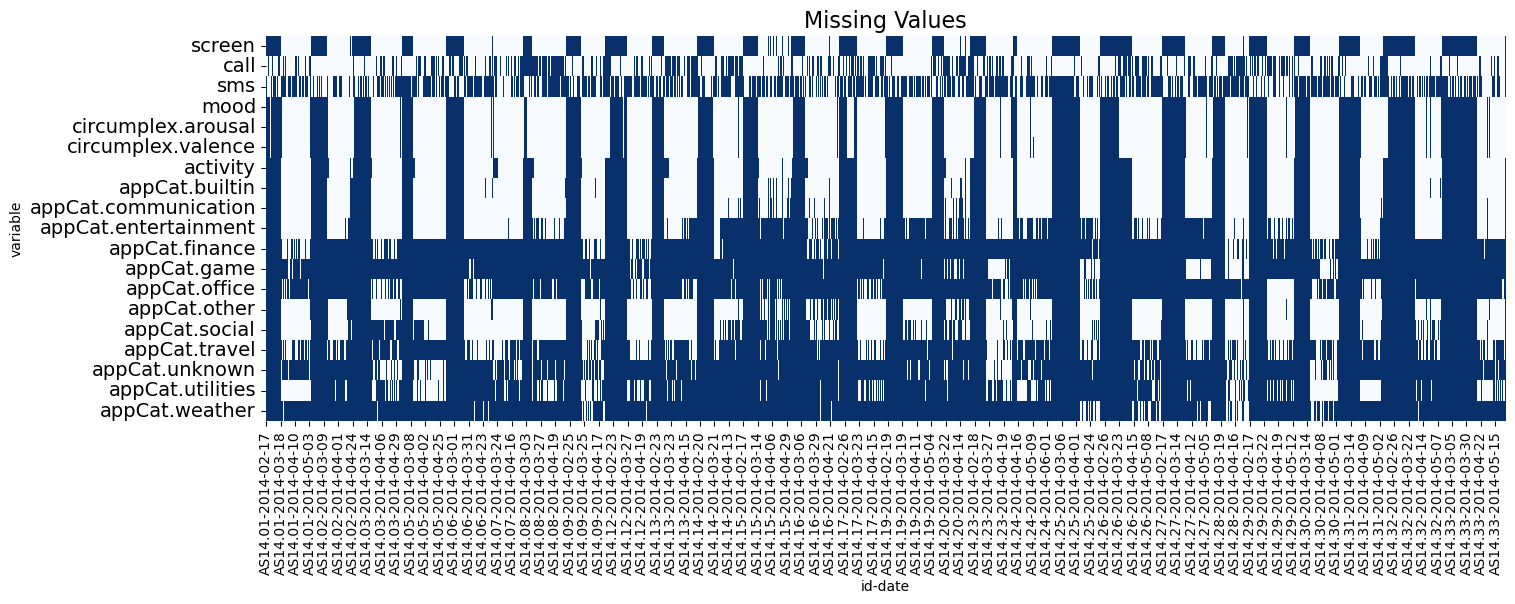

In [19]:
plt.figure(figsize=(16, 5))
sns.heatmap(daily_data.set_index(['id', 'date']).T.isna(), cmap='Blues', cbar=False)
plt.title('Missing Values', fontsize=16)
plt.yticks(fontsize=14, rotation=0) 
plt.xticks(rotation=90)
plt.show()

# 2.4) Drop columns

In [21]:
daily_data.columns

Index(['id', 'date', 'screen', 'call', 'sms', 'mood', 'circumplex.arousal',
       'circumplex.valence', 'activity', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities',
       'appCat.weather'],
      dtype='object', name='variable')

In [22]:
columns_to_drop = ['appCat.finance', 'appCat.game', 'appCat.office', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

# Dropping the columns from the DataFrame
daily_data = daily_data.drop(columns=columns_to_drop)

In [23]:
daily_data


variable,id,date,screen,call,sms,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social
0,AS14.01,2014-02-17,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AS14.01,2014-02-18,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AS14.01,2014-02-19,NaN,7.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AS14.01,2014-02-20,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AS14.01,2014-02-21,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1968,AS14.33,2014-05-27,4089.879001,1.0,2.0,6.2,-0.600000,0.4,0.012704,726.391,2078.403,124.694,142.686,2010.364
1969,AS14.33,2014-05-28,14320.867998,10.0,1.0,8.2,0.000000,1.2,0.103301,2551.046,1936.415,614.706,529.946,5361.211
1970,AS14.33,2014-05-29,3569.341000,5.0,1.0,7.0,-1.333333,1.0,0.169354,400.034,435.105,136.738,29.202,1789.922
1971,AS14.33,2014-05-30,9497.646999,4.0,NaN,6.8,-0.800000,-0.4,0.192901,3044.030,1670.842,260.220,52.610,3166.409


# 3. EDA\ Outliers & Imputations

                                   Numeric Features Distribution                                    


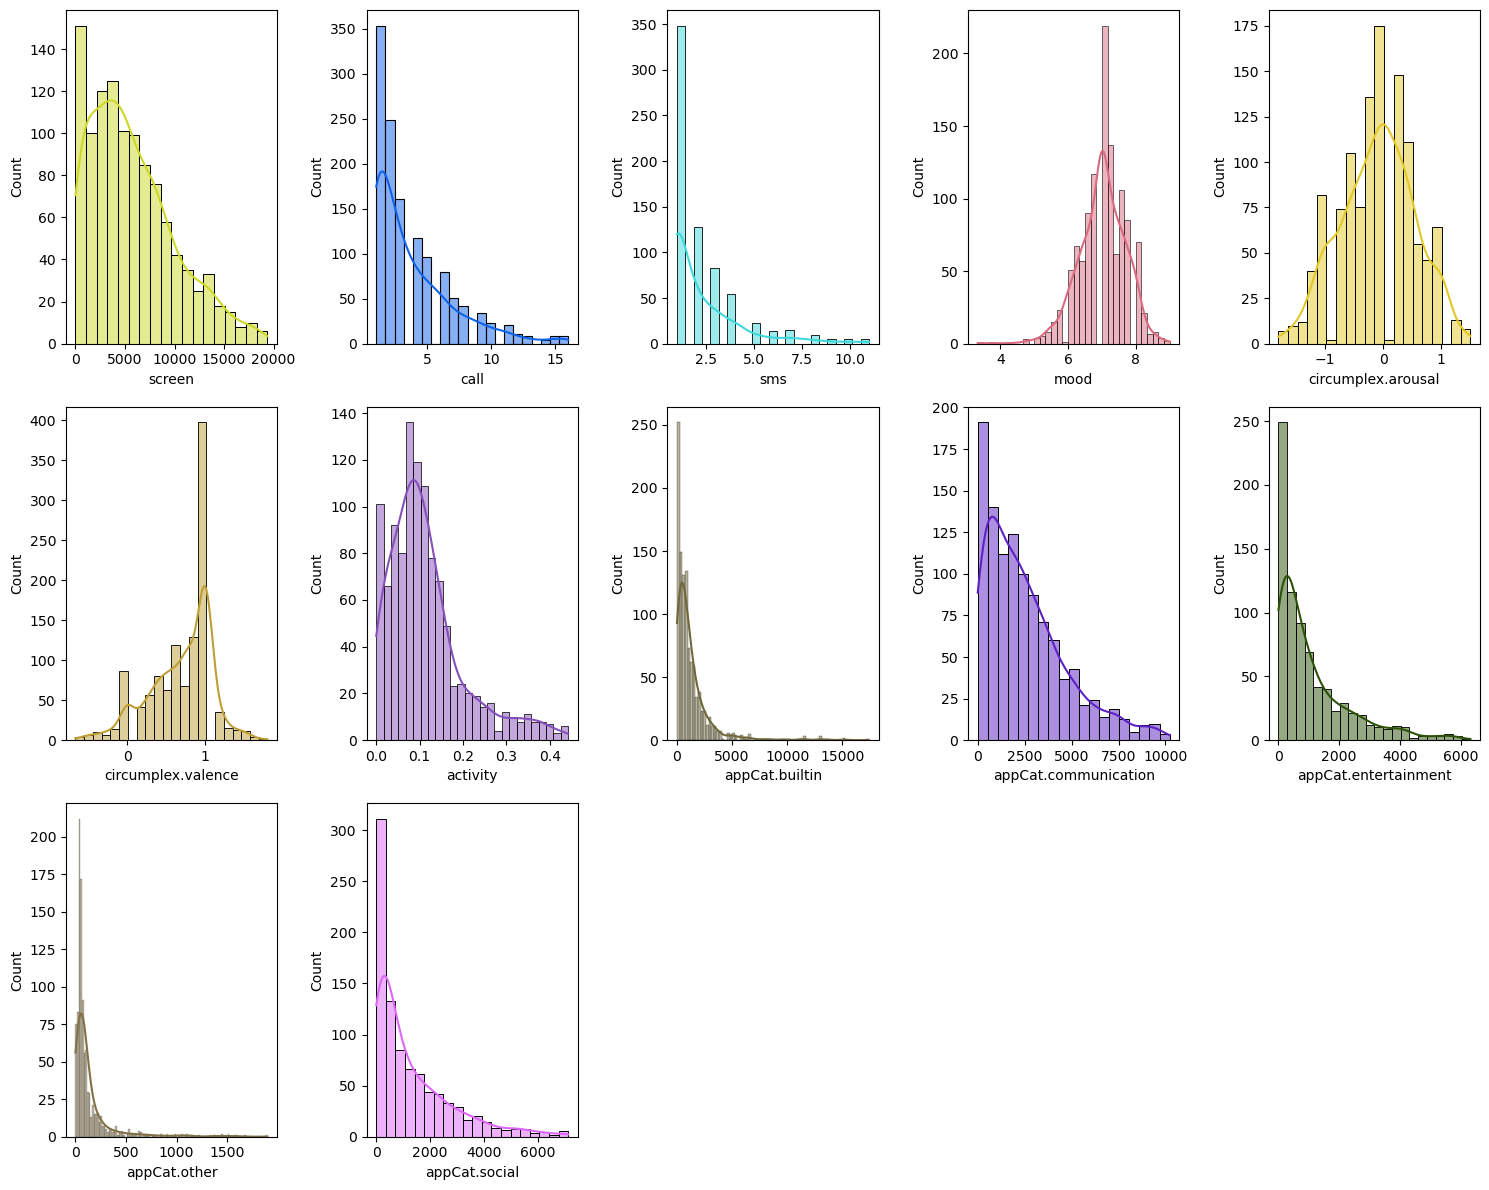

In [77]:
# List of numeric features in the dataframe
nf = daily_data.select_dtypes(include=[np.number]).columns.tolist()
print('\033[1m' + 'Numeric Features Distribution'.center(100) + '\033[0m')

n = 5  # Number of columns in your subplot
plt.figure(figsize=[15, 4 * math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n), n, i+1)
    sns.histplot(daily_data[nf[i]], kde=True, color=list(np.random.rand(3,)))  # Changed to sns.histplot() for newer versions of seaborn
    plt.xlabel(nf[i])
    plt.tight_layout()

plt.show()

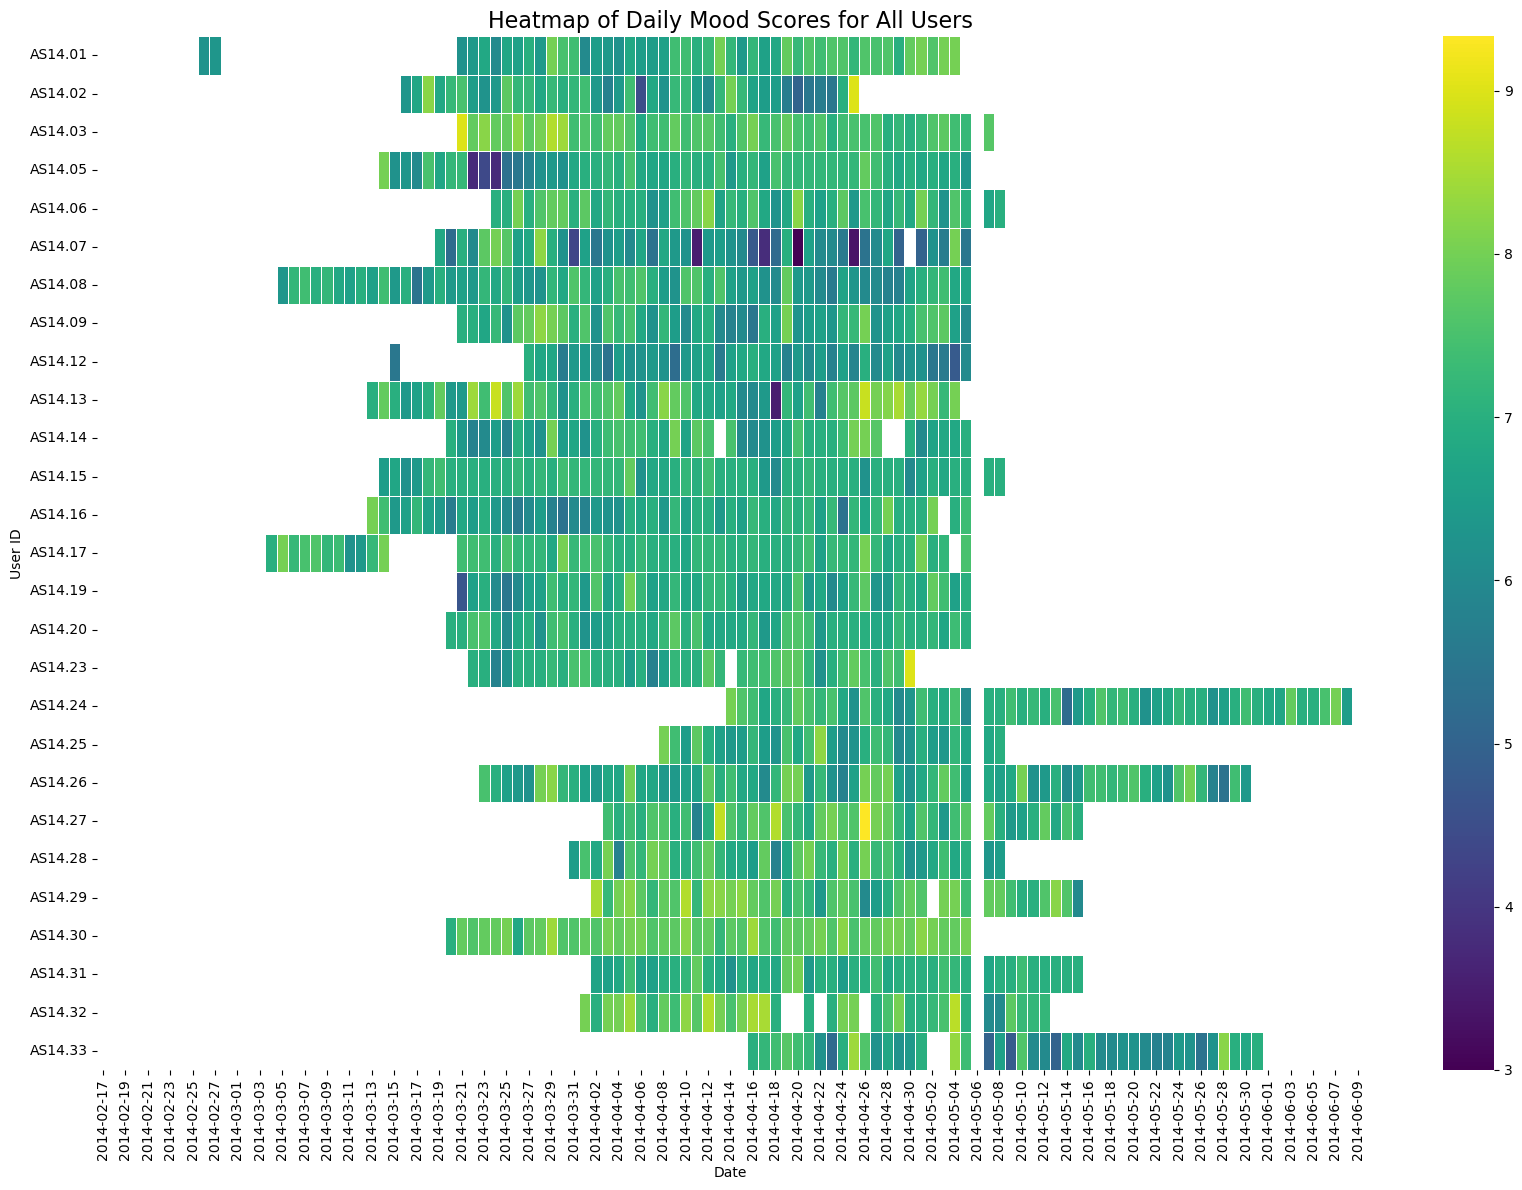

In [26]:
# Format the 'date' column to 'YYYY-MM-DD' strings
daily_data['date'] = pd.to_datetime(daily_data['date'])
daily_data['date'] = daily_data['date'].dt.strftime('%Y-%m-%d')
heatmap_data = daily_data.pivot(index='id', columns='date', values='mood')

# Plot the heatmap
plt.figure(figsize=(17, 12))  # Adjust the figure size as needed
sns.heatmap(heatmap_data, cmap='viridis', linewidths=.5)
plt.title('Heatmap of Daily Mood Scores for All Users', fontsize=16)
plt.xlabel('Date')
plt.ylabel('User ID')
plt.xticks(rotation=90)
plt.tight_layout()  
plt.show()

# 3.1) Isolation Forest

In [28]:
daily_data['date'] = pd.to_datetime(daily_data['date'])
daily_data['id'] = daily_data['id'].astype(str)

iso_data = daily_data.copy()

# Initialize a dictionary to hold the outlier detection results
outliers_dict = {}

for column in iso_data.select_dtypes(include=[np.number]).columns:
    data_column = iso_data[[column]].dropna()
    
    if not data_column.empty: 
        # Initialize the Isolation Forest
        iso_forest = IsolationForest(contamination=0.01, random_state=42)  # Adjust contamination as needed
        
        # Fit the model and predict anomalies
        iso_forest.fit(data_column)
        anomalies = iso_forest.predict(data_column.values.reshape(-1, 1))
        
        # Convert predictions to a boolean array: True for anomalies, False for normal
        anomalies = anomalies == -1
        
        # Store the results in the DataFrame using the index from the dropped NaNs
        iso_data.loc[data_column.index, column + '_outliers'] = anomalies

# Fill NaN in outlier columns with False 
for col in iso_data.columns:
    if 'outliers' in col:
        iso_data[col] = iso_data[col].fillna(False)

for column in iso_data.columns:
    if 'outliers' in column:
        print(f"Number of outliers detected in {column.replace('_outliers', '')}: {iso_data[column].sum()}")


C:\Users\konst\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\konst\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\konst\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\konst\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\konst\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\konst\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have va

Number of outliers detected in screen: 13
Number of outliers detected in call: 12
Number of outliers detected in sms: 8
Number of outliers detected in mood: 11
Number of outliers detected in circumplex.arousal: 12
Number of outliers detected in circumplex.valence: 13
Number of outliers detected in activity: 12
Number of outliers detected in appCat.builtin: 12
Number of outliers detected in appCat.communication: 12
Number of outliers detected in appCat.entertainment: 9
Number of outliers detected in appCat.other: 12
Number of outliers detected in appCat.social: 10


In [29]:
# Create a copy of 'daily_data' for manipulation and rename it to 'heatmap_data2'
iso_data2 = daily_data.copy()

# Loop through each numeric variable and apply Isolation Forest
for column in iso_data2.select_dtypes(include=[np.number]).columns:
    data_column = iso_data2[[column]].dropna()
    if not data_column.empty:
        iso_forest = IsolationForest(contamination=0.01, random_state=42)
        anomalies = iso_forest.fit_predict(data_column.values.reshape(-1, 1))
        iso_data2.loc[data_column.index, column + '_outliers'] = anomalies == -1

# Fill NaN in outlier columns with False in 'heatmap_data2'
for col in iso_data2.columns:
    if 'outliers' in col:
        iso_data2[col] = iso_data2[col].fillna(False)

# Exclude 'mood_outliers' from the columns used to flag rows for removal
outlier_columns = [col for col in iso_data2.filter(like='_outliers').columns if col != 'mood_outliers']
outlier_flags = iso_data2[outlier_columns].any(axis=1)

# Filter out outliers from the original daily_data based on the flags from 'iso_data2'
cleaned_data = daily_data[~outlier_flags]


In [30]:
cleaned_data
daily_data=cleaned_data

# 3.2) Deleting dates with big amount of mood missing data

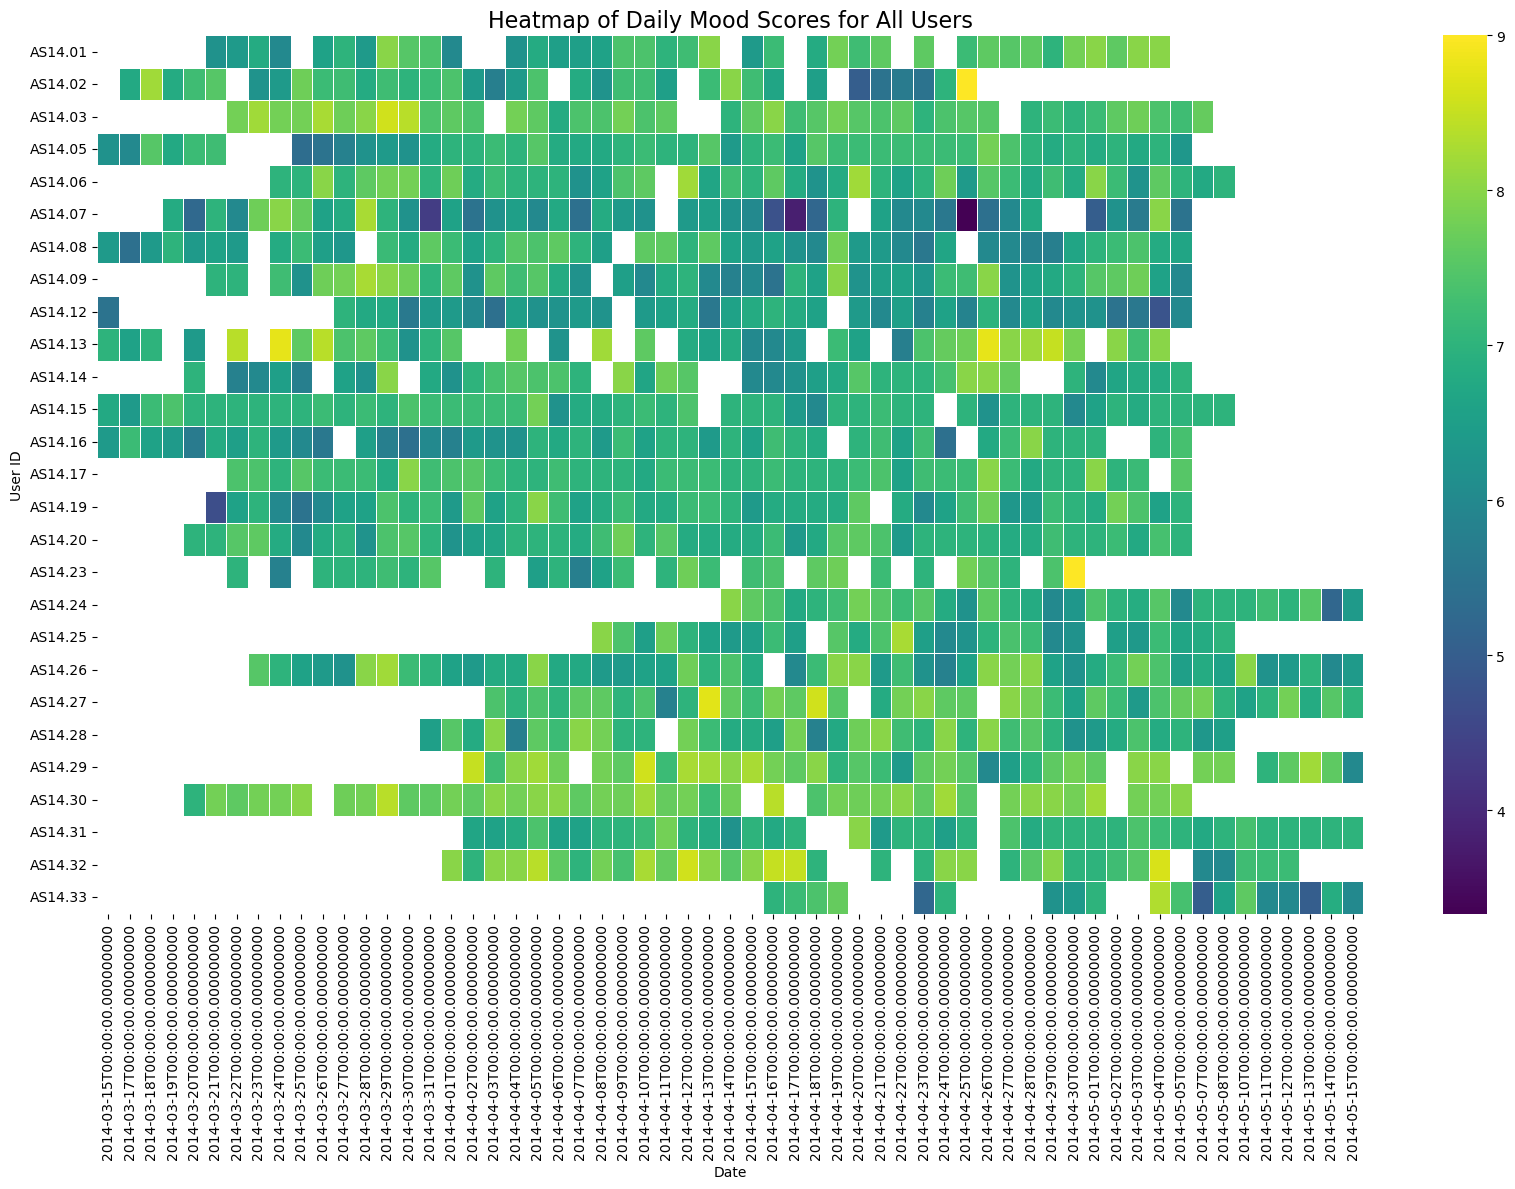

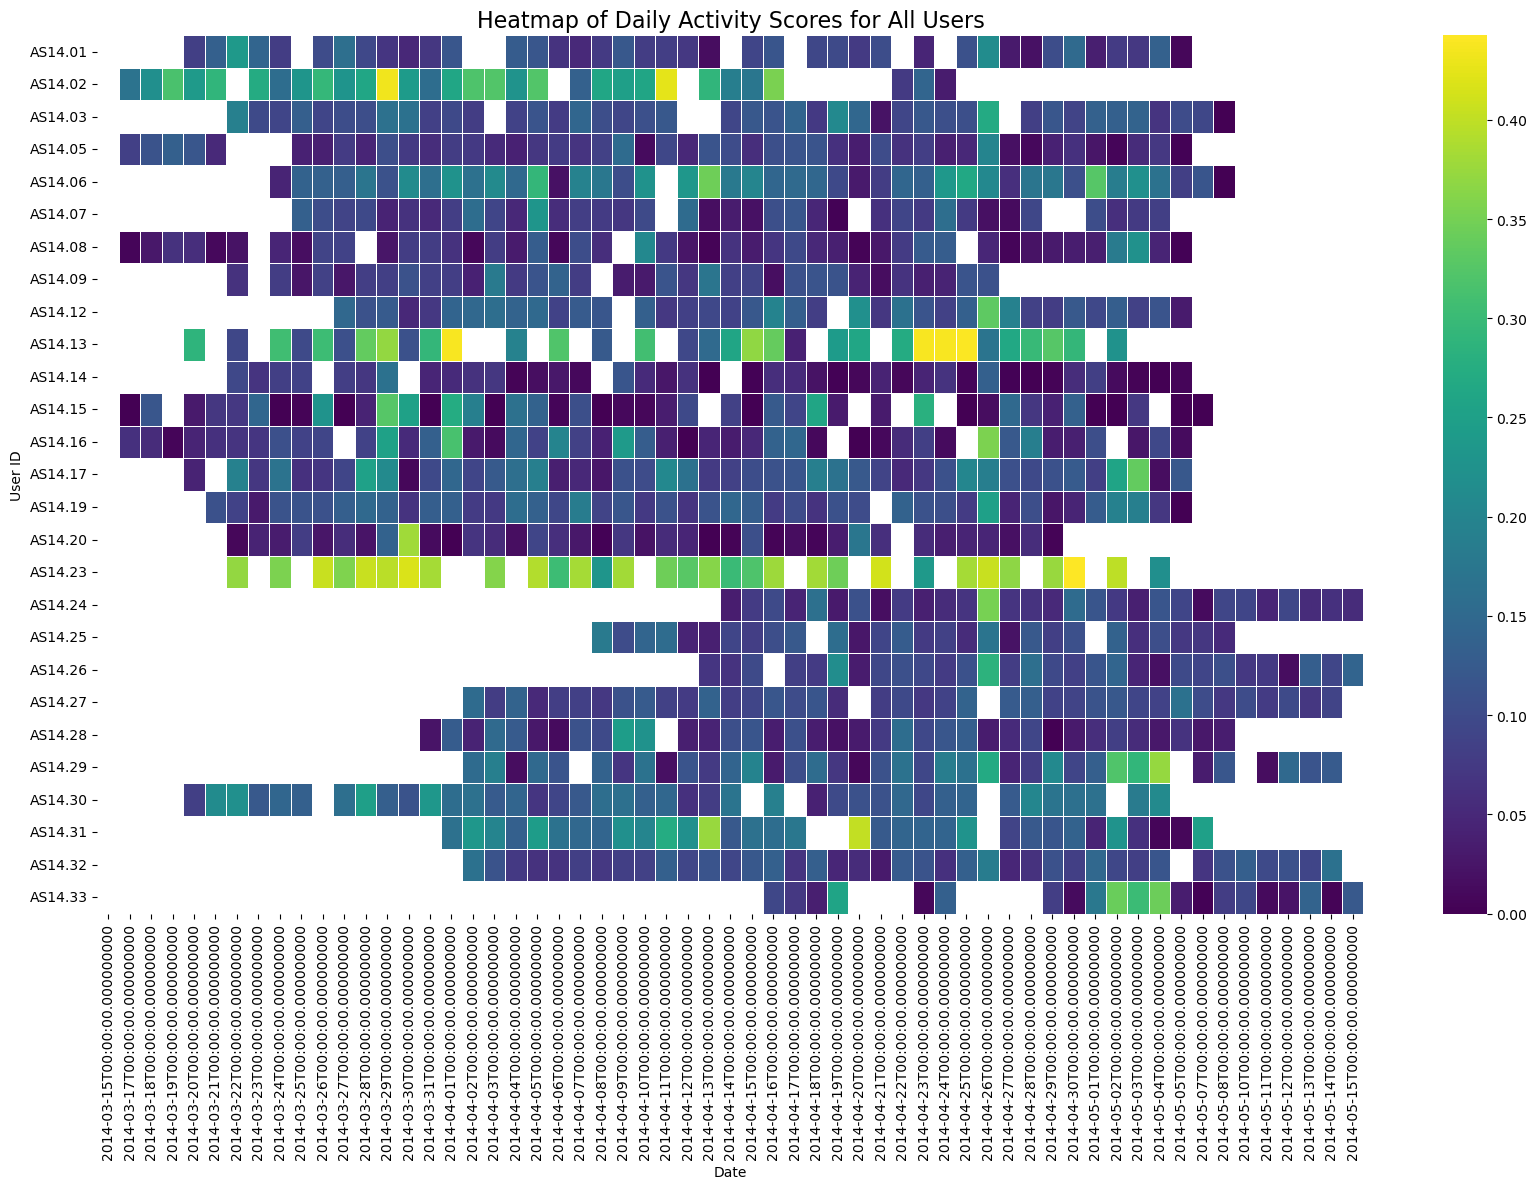

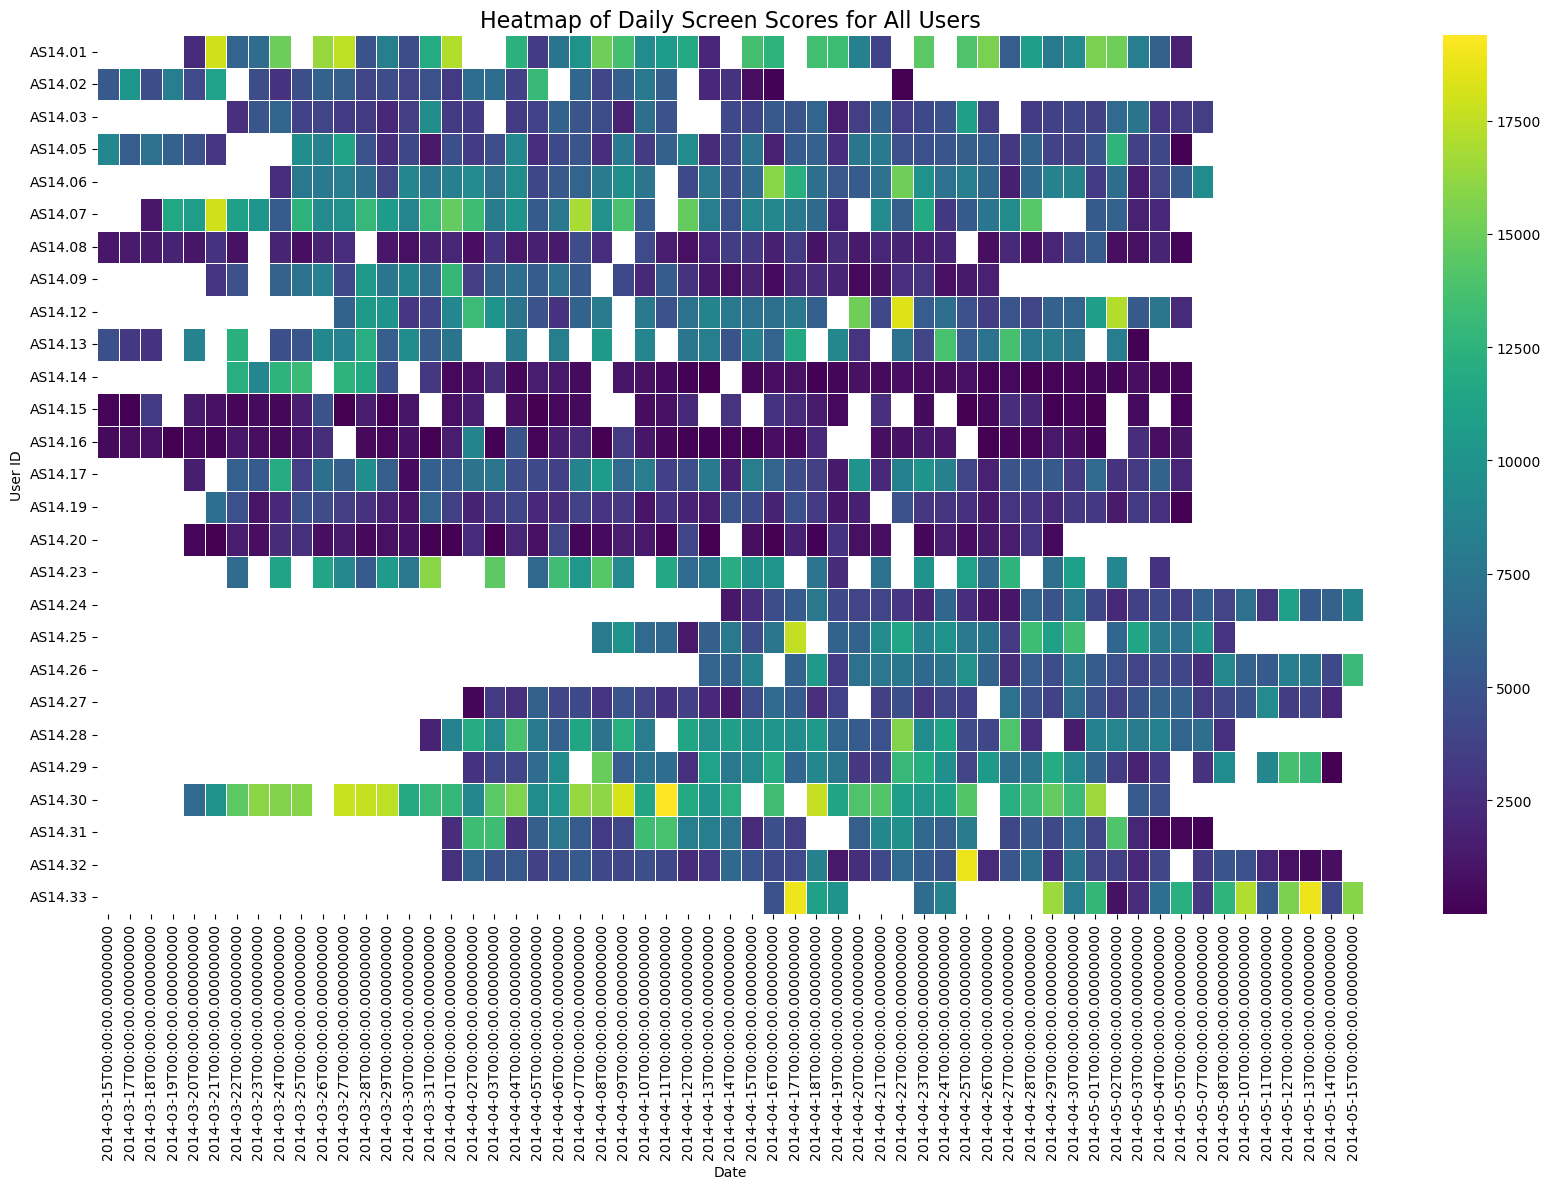

In [32]:
# Function to filter dates based on missing mood data
def filter_dates_by_mood(data, user_ids, threshold_percentage):
    mood_counts_by_date = data.groupby('date')['mood'].count()
    threshold = len(user_ids) * threshold_percentage / 100
    dates_to_keep = mood_counts_by_date[mood_counts_by_date >= threshold].index
    return data[data['date'].isin(dates_to_keep)]
user_ids = ['AS14.01', 'AS14.02', 'AS14.03', 'AS14.05', 'AS14.06', 'AS14.07',
       'AS14.08', 'AS14.09', 'AS14.12', 'AS14.13', 'AS14.14', 'AS14.15',
       'AS14.16', 'AS14.17', 'AS14.19', 'AS14.20', 'AS14.23', 'AS14.24',
       'AS14.25', 'AS14.26', 'AS14.27', 'AS14.28', 'AS14.29', 'AS14.30',
       'AS14.31', 'AS14.32','AS14.33']

threshold_percentage = 20
daily_data_filtered = filter_dates_by_mood(daily_data, user_ids, threshold_percentage)


def plot_heatmap(data, value_column):
    heatmap_data = data.pivot(index='id', columns='date', values=value_column)
    plt.figure(figsize=(17, 12))
    sns.heatmap(heatmap_data, cmap='viridis', linewidths=.5)
    plt.title(f'Heatmap of Daily {value_column.title()} Scores for All Users', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('User ID')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


plot_heatmap(daily_data_filtered, 'mood')
plot_heatmap(daily_data_filtered, 'activity')
plot_heatmap(daily_data_filtered, 'screen')

In [33]:
daily_data_filtered

variable,id,date,screen,call,sms,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social
20,AS14.01,2014-03-15,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,AS14.01,2014-03-17,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,AS14.01,2014-03-18,NaN,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,AS14.01,2014-03-19,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,AS14.01,2014-03-20,2275.944000,1.0,NaN,NaN,NaN,NaN,0.081548,248.979,2168.229,350.856,11.345,807.731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1952,AS14.33,2014-05-11,5336.354001,NaN,NaN,6.000000,0.000000,0.4,0.011163,259.893,504.549,357.637,53.551,4154.944
1953,AS14.33,2014-05-12,15521.871000,1.0,NaN,6.000000,-0.750000,0.5,0.024017,1196.532,1065.885,474.836,293.233,4037.567
1954,AS14.33,2014-05-13,18801.167999,1.0,NaN,5.000000,0.500000,0.0,0.139964,2505.530,4340.772,1232.103,39.548,3313.274
1955,AS14.33,2014-05-14,4149.179000,NaN,NaN,6.833333,-0.333333,0.4,0.003986,268.980,160.882,1093.614,100.961,3754.772


# 3.3) Imputing with KNN

In [35]:
non_numeric_data = daily_data_filtered[['id', 'date']].copy()

# Perform KNN imputation on the numerical part of the data
imputer = KNNImputer(n_neighbors=5)
numeric_data = daily_data_filtered.select_dtypes(include=[float, int])  # Selecting only numerical columns
imputed_data = imputer.fit_transform(numeric_data)  # Imputation

# Convert the imputed array back to a DataFrame with appropriate column names
imputed_df = pd.DataFrame(imputed_data, columns=numeric_data.columns)

# Concatenate the non-numeric and imputed numeric data back together
# Ensure that the indices align. If the indices don't align, you may need to reset them before concatenation.
daily_data_imputed = pd.concat([non_numeric_data, imputed_df], axis=1)
daily_data_imputed = non_numeric_data.reset_index(drop=True).join(imputed_df.reset_index(drop=True))

In [36]:
missing_values = daily_data_imputed.isnull().sum()
missing_percentage = (missing_values / len(daily_data_imputed)) * 100

missing_values, missing_percentage

(variable
 id                      0
 date                    0
 screen                  0
 call                    0
 sms                     0
 mood                    0
 circumplex.arousal      0
 circumplex.valence      0
 activity                0
 appCat.builtin          0
 appCat.communication    0
 appCat.entertainment    0
 appCat.other            0
 appCat.social           0
 dtype: int64,
 variable
 id                      0.0
 date                    0.0
 screen                  0.0
 call                    0.0
 sms                     0.0
 mood                    0.0
 circumplex.arousal      0.0
 circumplex.valence      0.0
 activity                0.0
 appCat.builtin          0.0
 appCat.communication    0.0
 appCat.entertainment    0.0
 appCat.other            0.0
 appCat.social           0.0
 dtype: float64)

In [37]:
missing_values_2 = daily_data_filtered.isnull().sum()
missing_percentage_2 = (missing_values_2 / len(daily_data_filtered)) * 100

missing_values_2, missing_percentage_2

(variable
 id                        0
 date                      0
 screen                  244
 call                    495
 sms                     839
 mood                    195
 circumplex.arousal      195
 circumplex.valence      196
 activity                250
 appCat.builtin          256
 appCat.communication    267
 appCat.entertainment    544
 appCat.other            317
 appCat.social           435
 dtype: int64,
 variable
 id                       0.000000
 date                     0.000000
 screen                  19.182390
 call                    38.915094
 sms                     65.959119
 mood                    15.330189
 circumplex.arousal      15.330189
 circumplex.valence      15.408805
 activity                19.654088
 appCat.builtin          20.125786
 appCat.communication    20.990566
 appCat.entertainment    42.767296
 appCat.other            24.921384
 appCat.social           34.198113
 dtype: float64)

# 3.4) Interpolation and Backfill

In [39]:
daily_data_filtered_2 = daily_data_filtered.copy()

# interpolate numeric cols
num_cols = daily_data_filtered_2.select_dtypes(include="number").columns
daily_data_filtered_2[num_cols] = (
    daily_data_filtered_2[num_cols]
        .astype("float64")                      # handle nullable Int64, etc.
        .interpolate(method="linear", limit_direction="both")
)

# for non-numeric, just carry values
non_num_cols = daily_data_filtered_2.columns.difference(num_cols)
daily_data_filtered_2[non_num_cols] = (
    daily_data_filtered_2[non_num_cols].ffill().bfill()
)

daily_data_imputed_2 = daily_data_filtered_2

missing_values_3 = daily_data_imputed_2.isnull().sum()
missing_percentage_3 = (missing_values_3 / len(daily_data_imputed_2)) * 100

missing_values_3, missing_percentage_3

(variable
 id                      0
 date                    0
 screen                  0
 call                    0
 sms                     0
 mood                    0
 circumplex.arousal      0
 circumplex.valence      0
 activity                0
 appCat.builtin          0
 appCat.communication    0
 appCat.entertainment    0
 appCat.other            0
 appCat.social           0
 dtype: int64,
 variable
 id                      0.0
 date                    0.0
 screen                  0.0
 call                    0.0
 sms                     0.0
 mood                    0.0
 circumplex.arousal      0.0
 circumplex.valence      0.0
 activity                0.0
 appCat.builtin          0.0
 appCat.communication    0.0
 appCat.entertainment    0.0
 appCat.other            0.0
 appCat.social           0.0
 dtype: float64)

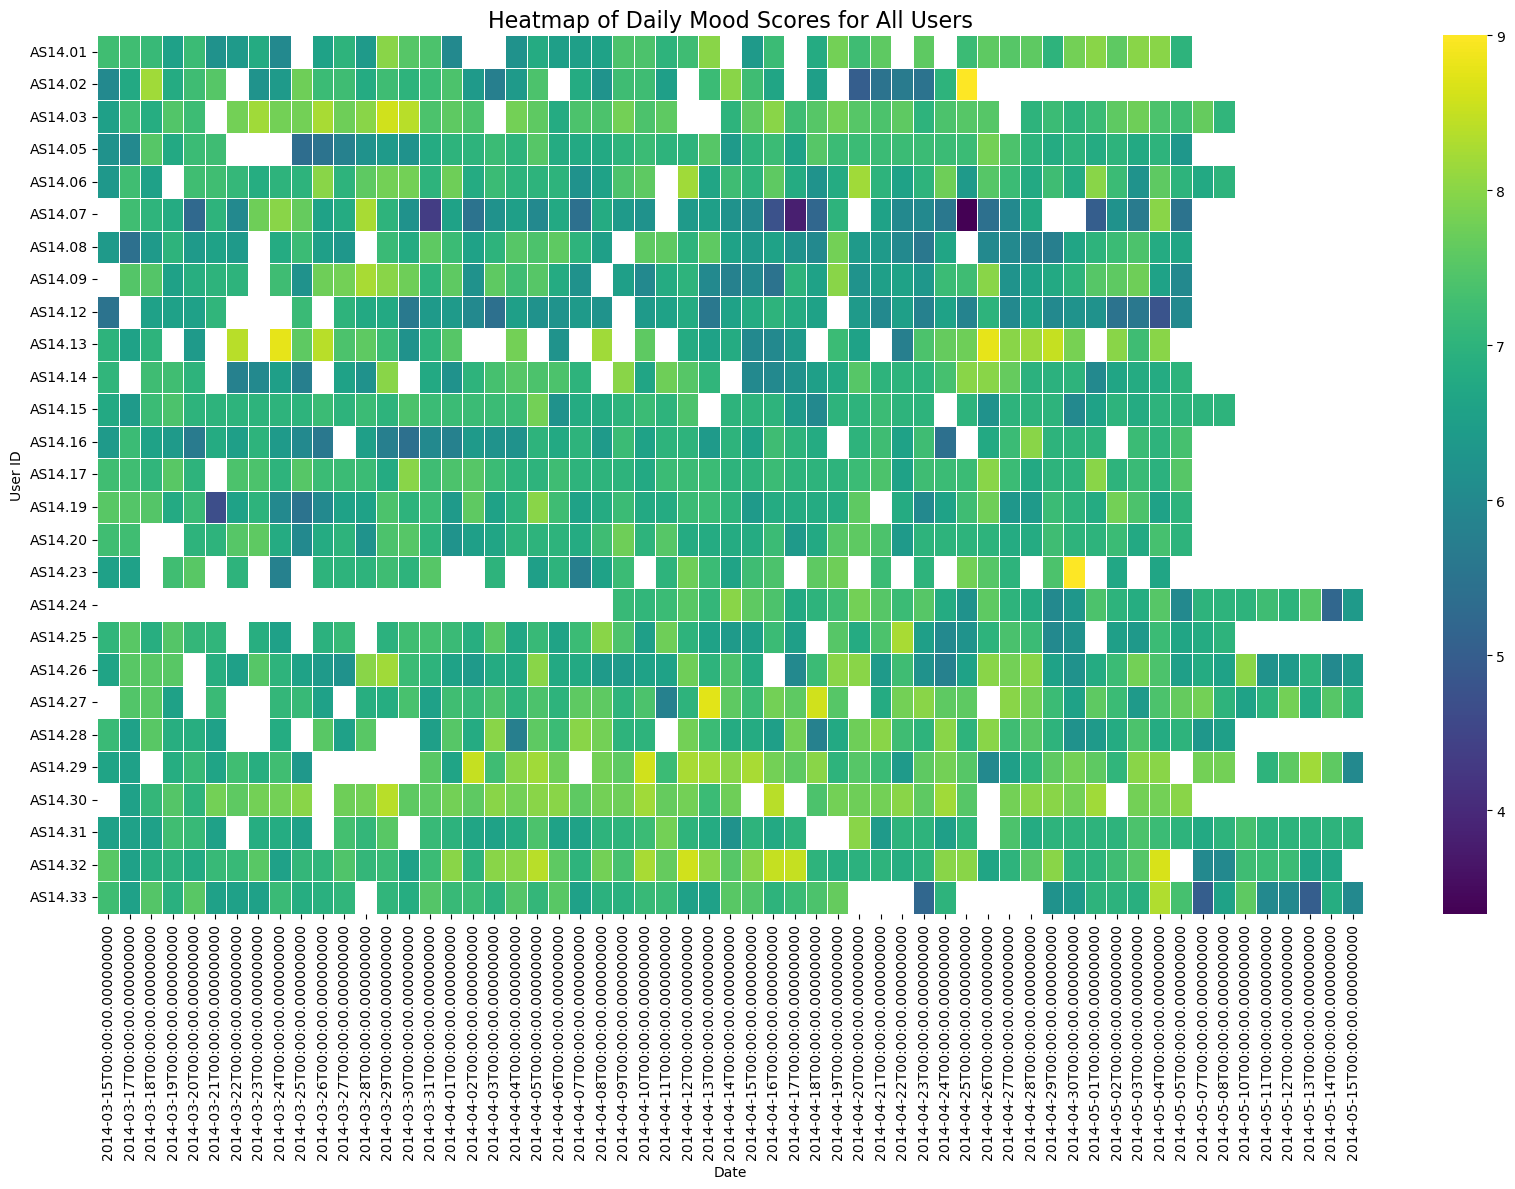

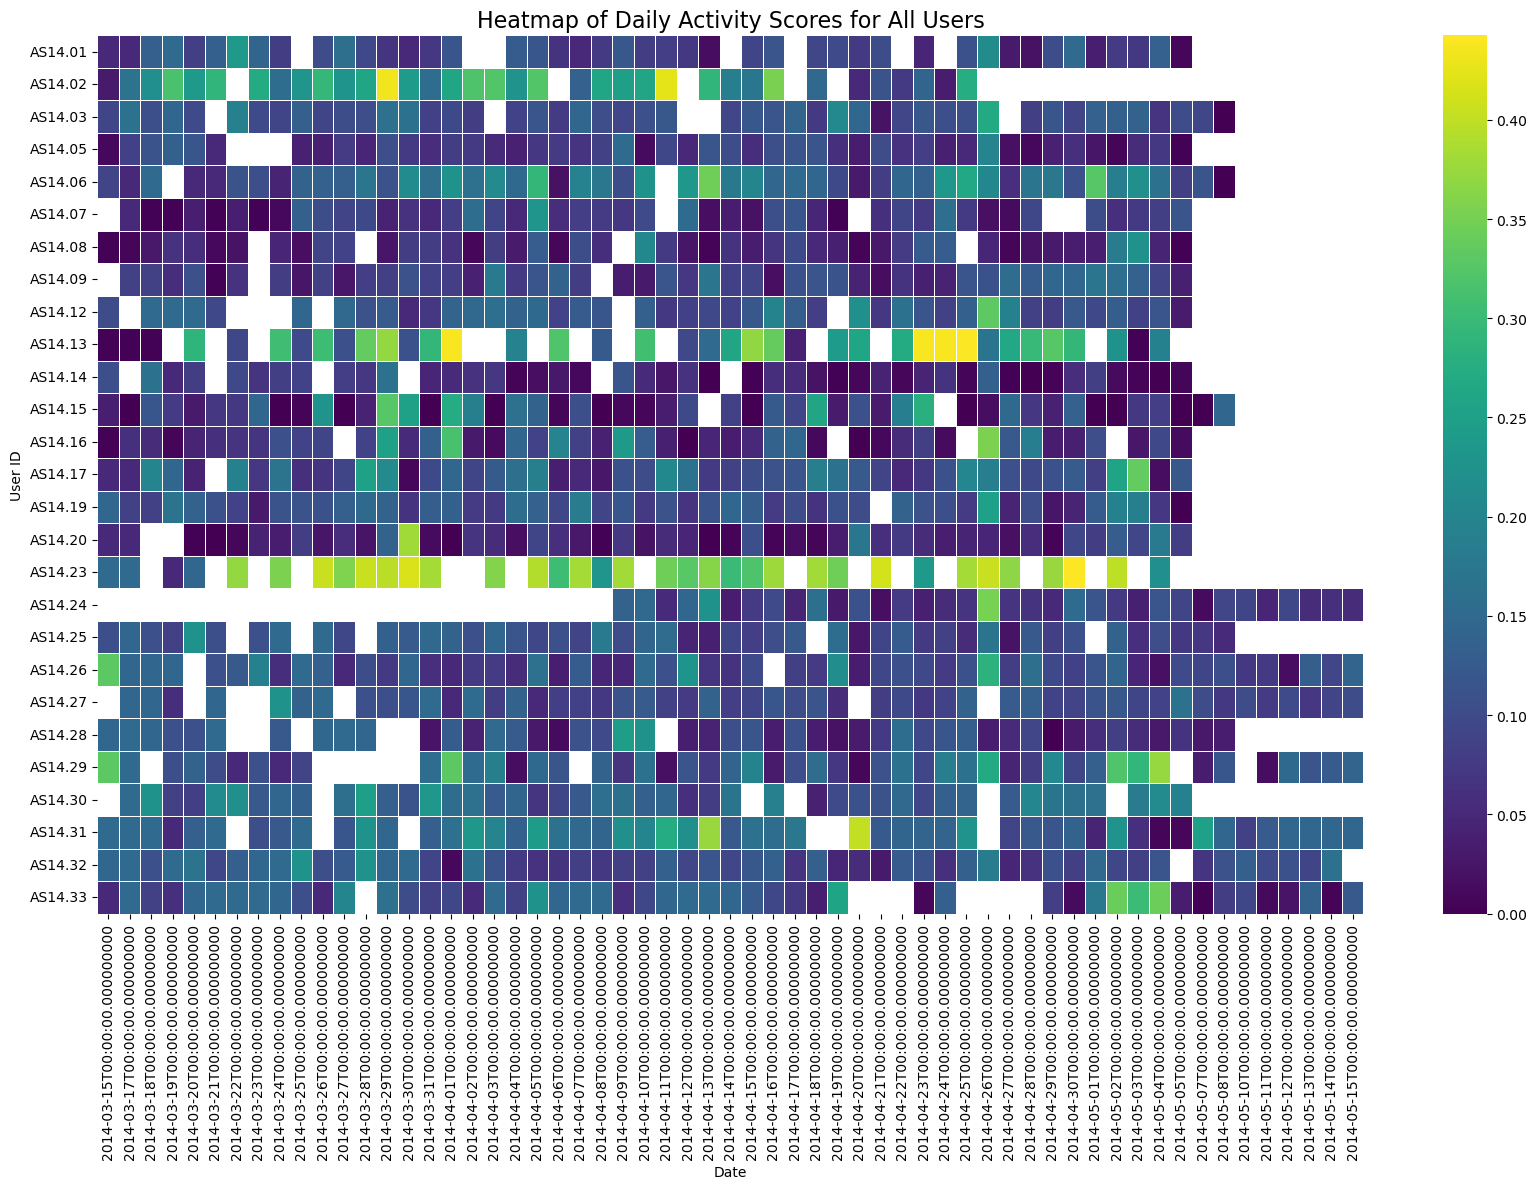

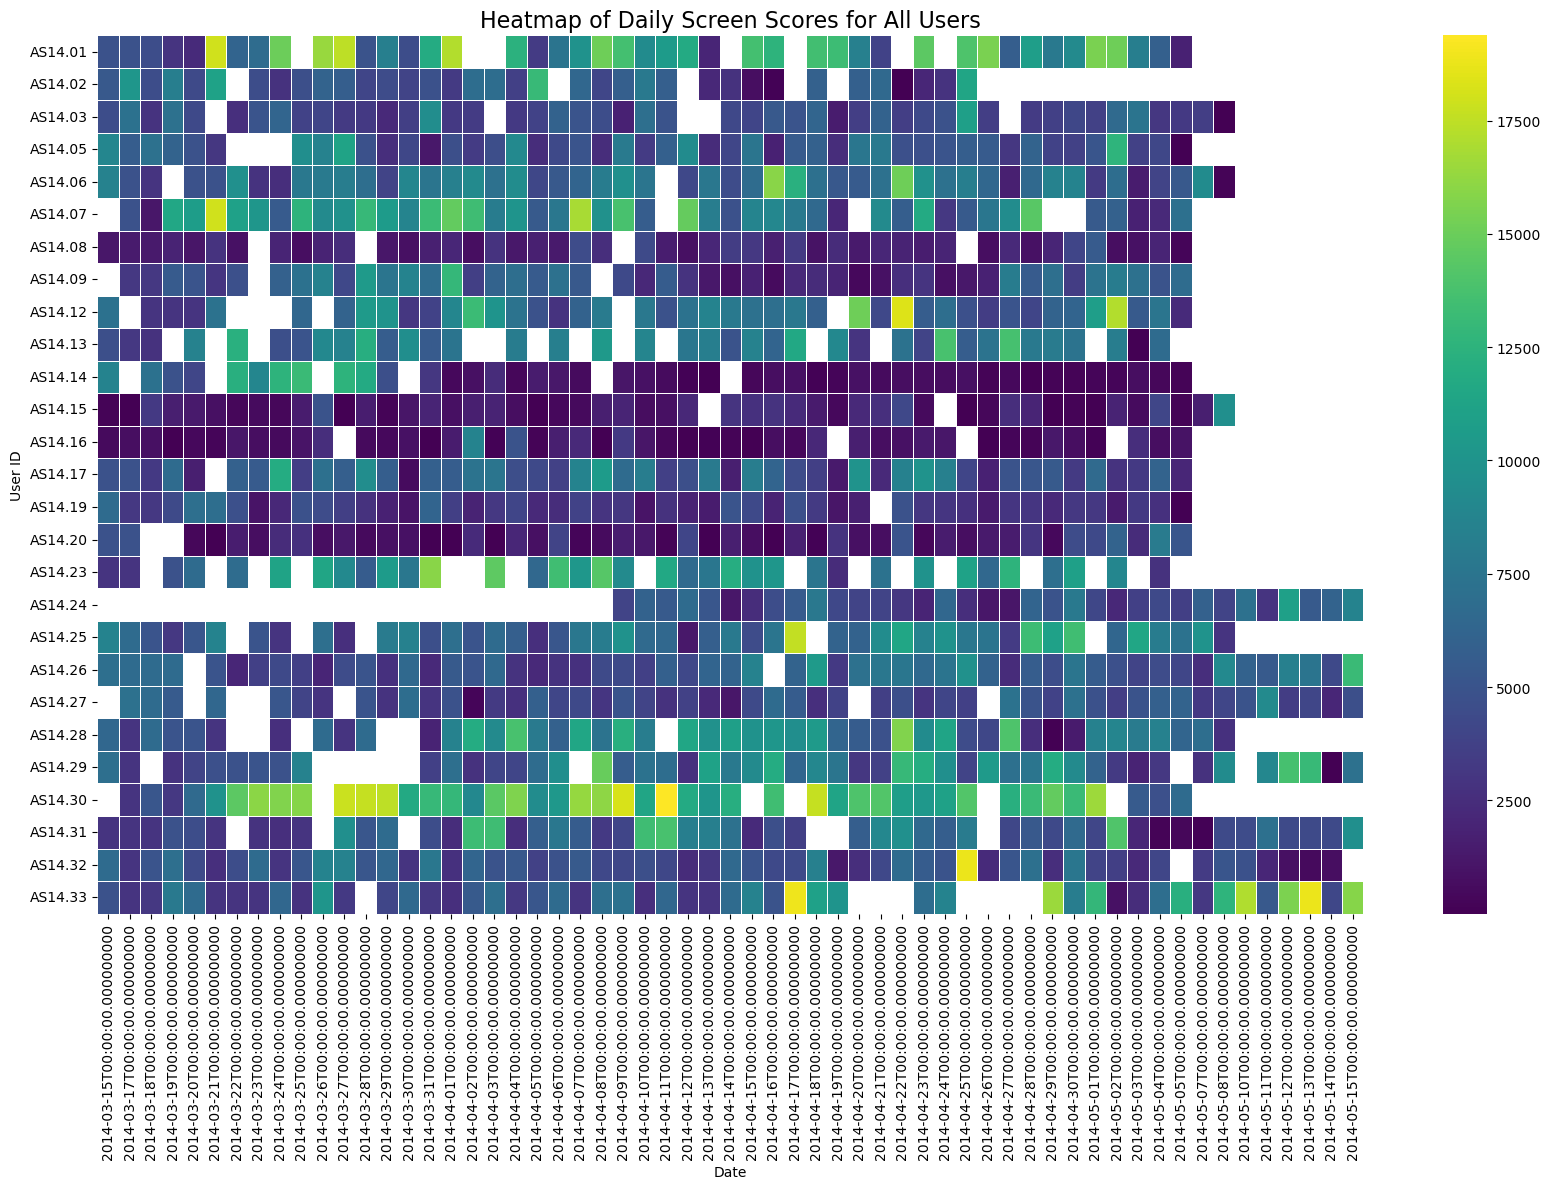

In [40]:
# Function to plot heatmap for daily data
def plot_heatmap(data, value_column):
    heatmap_data = data.pivot(index='id', columns='date', values=value_column)
    plt.figure(figsize=(17, 12))
    sns.heatmap(heatmap_data, cmap='viridis', linewidths=.5)
    plt.title(f'Heatmap of Daily {value_column.title()} Scores for All Users', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('User ID')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Plotting heatmaps for mood, activity, and screen using the same filtered dates
plot_heatmap(daily_data_imputed, 'mood')
plot_heatmap(daily_data_imputed, 'activity')
plot_heatmap(daily_data_imputed, 'screen')

In [41]:
daily_data_imputed

variable,id,date,screen,call,sms,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.other,appCat.social
0,AS14.01,2014-03-15,4873.140800,6.0,1.0,7.270000,-0.400000,0.620000,0.049001,441.5332,1728.0884,1855.3920,192.0246,876.7360
1,AS14.01,2014-03-17,4873.140800,6.0,1.0,7.270000,-0.400000,0.620000,0.049001,441.5332,1728.0884,1855.3920,192.0246,876.7360
2,AS14.01,2014-03-18,4535.069000,1.0,2.0,7.150000,-0.123333,0.716667,0.131613,1770.4486,3918.0898,692.5764,430.8046,703.4910
3,AS14.01,2014-03-19,2879.106800,1.0,2.8,6.553333,-0.020000,0.633333,0.150912,3301.2994,3603.9096,602.7210,69.0396,333.4178
4,AS14.01,2014-03-20,2275.944000,1.0,1.6,7.190000,0.036667,0.403333,0.081548,248.9790,2168.2290,350.8560,11.3450,807.7310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,AS14.33,2014-05-11,5336.354001,3.2,2.8,6.000000,0.000000,0.400000,0.011163,259.8930,504.5490,357.6370,53.5510,4154.9440
1268,AS14.33,2014-05-12,15521.871000,1.0,2.0,6.000000,-0.750000,0.500000,0.024017,1196.5320,1065.8850,474.8360,293.2330,4037.5670
1269,AS14.33,2014-05-13,18801.167999,1.0,2.0,5.000000,0.500000,0.000000,0.139964,2505.5300,4340.7720,1232.1030,39.5480,3313.2740
1270,AS14.33,2014-05-14,4149.179000,1.6,3.0,6.833333,-0.333333,0.400000,0.003986,268.9800,160.8820,1093.6140,100.9610,3754.7720


In [42]:
daily_data_imputed.to_csv('data_for_FE.csv')